# IAB딥러닝 10월 18일
> 이미지자료분석 --> CNN 예비학습, CNN구현 (CPU), CNN구현 (GPU), BCEWithLogisticLoss

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김준형

# Import

In [1]:
import torch
import torchvision
from fastai.vision.all import *
import time

# Data

`-` Download Data

In [3]:
path = untar_data(URLs.MNIST)

`-` Training Set

In [5]:
X0 = torch.stack([torchvision.io.read_image(Str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X = torch.concat([X0, X1]) / 255
y = torch.tensor([0.0] * len(X0) + [1.0] * len(X1)).reshape(-1, 1)

`-` Test Set

In [63]:
X0 = torch.stack([torchvision.io.read_image(Str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
XX = torch.concat([X0, X1]) / 255
yy = torch.tensor([0.0] * len(X0) + [1.0] * len(X1)).reshape(-1, 1)

In [64]:
X.shape, XX.shape, y.shape, yy.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([2115, 1, 28, 28]),
 torch.Size([12665, 1]),
 torch.Size([2115, 1]))

# CNN 예비학습

## 새로운 아키텍처의 제시

`-` 예전

$\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,30)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,30)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 새로운 아키텍처 
- $conv$: feature를 뻥튀기하는 역할 (2d ver $l_1$ 느낌) 
- $relu$: 
- $pooling$: 데이터를 요약하는 역할 

## CONV 레이어 (선형변환의 2D 버전)

**(예시 1)**

In [8]:
torch.manual_seed(201715447)
_conv = torch.nn.Conv2d(1, 1, (2, 2))
_conv.weight.data, _conv.bias.data

(tensor([[[[ 0.3475, -0.1602],
           [-0.3039, -0.4139]]]]),
 tensor([-0.2540]))

In [9]:
_X = torch.arange(0, 4).reshape(1, 2, 2).float()
_X

tensor([[[0., 1.],
         [2., 3.]]])

In [14]:
(0.3475) * 0 + (-0.1602) * 1 + (-0.3039) * 2 + (-0.4139) * 3 + -0.2540

-2.2637

In [13]:
_conv(_X)

tensor([[[-2.2638]]], grad_fn=<SqueezeBackward1>)

**(예시 2)** 평균구하기

In [15]:
_conv.weight.data = torch.tensor([[[[1/4, 1/4], [1/4, 1/4]]]])
_conv.bias.data = torch.tensor([0.0])

In [16]:
_conv(_X), (0 + 1 + 2 + 3) / 4

(tensor([[[1.5000]]], grad_fn=<SqueezeBackward1>), 1.5)

**(예시 3)** 이동평균

In [17]:
_X = torch.arange(0, 25).float().reshape(1, 5, 5)
_X

tensor([[[ 0.,  1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.,  9.],
         [10., 11., 12., 13., 14.],
         [15., 16., 17., 18., 19.],
         [20., 21., 22., 23., 24.]]])

In [18]:
_conv(_X)

tensor([[[ 3.,  4.,  5.,  6.],
         [ 8.,  9., 10., 11.],
         [13., 14., 15., 16.],
         [18., 19., 20., 21.]]], grad_fn=<SqueezeBackward1>)

**(예시 4)** window size가 증가한다면? (2d 이동평균느낌)

In [19]:
_conv = torch.nn.Conv2d(1, 1, (3, 3))
_conv.bias.data = torch.tensor([0.0])
_conv.weight.data = torch.tensor([[[[1/9, 1/9, 1/9], [1/9, 1/9, 1/9], [1/9, 1/9, 1/9]]]])

In [22]:
_X, _conv(_X)

(tensor([[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]),
 tensor([[[ 6.0000,  7.0000,  8.0000],
          [11.0000, 12.0000, 13.0000],
          [16.0000, 17.0000, 18.0000]]], grad_fn=<SqueezeBackward1>))

**(예시 5)** 피처 증가시키기

In [23]:
_X = torch.tensor([1.0, 1.0, 1.0, 1.0]).reshape(1, 2, 2)
_X

tensor([[[1., 1.],
         [1., 1.]]])

In [25]:
_conv = torch.nn.Conv2d(1, 8, (2, 2))
_conv.weight.data.shape, _conv.bias.data.shape

(torch.Size([8, 1, 2, 2]), torch.Size([8]))

In [26]:
_conv(_X).reshape(-1)

tensor([ 0.1951,  1.3940,  0.6831,  0.5889,  0.2669, -0.3125,  0.8579,  0.1906],
       grad_fn=<ReshapeAliasBackward0>)

In [27]:
torch.sum(_conv.weight.data[0,...]) + _conv.bias.data[0], torch.sum(_conv.weight.data[1,...]) + _conv.bias.data[1]

(tensor(0.1951), tensor(1.3940))

결국 아래와 같이 계산하는 것과 같다.

In [28]:
torch.sum(_conv.weight.data, axis = (2, 3)).reshape(-1) + _conv.bias.data

tensor([ 0.1951,  1.3940,  0.6831,  0.5889,  0.2669, -0.3125,  0.8579,  0.1906])

In [29]:
_conv(_X).reshape(-1)

tensor([ 0.1951,  1.3940,  0.6831,  0.5889,  0.2669, -0.3125,  0.8579,  0.1906],
       grad_fn=<ReshapeAliasBackward0>)

## ReLU (2d)

In [30]:
_X = torch.randn(25).reshape(1, 5, 5)
_X

tensor([[[-0.0488,  0.2144, -1.0814,  0.4921,  1.2028],
         [ 0.8151,  0.6953,  0.9054,  0.3448,  1.6039],
         [-1.1941, -1.4877, -1.0516, -0.6973, -0.1105],
         [-0.0178,  1.0564, -1.2399,  0.4696, -0.1178],
         [ 1.0790, -0.9323, -1.8428, -0.9742, -2.0074]]])

In [31]:
a1 = torch.nn.ReLU()

In [32]:
a1(_X)

tensor([[[0.0000, 0.2144, 0.0000, 0.4921, 1.2028],
         [0.8151, 0.6953, 0.9054, 0.3448, 1.6039],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.0564, 0.0000, 0.4696, 0.0000],
         [1.0790, 0.0000, 0.0000, 0.0000, 0.0000]]])

## Maxpooling Layer

In [33]:
_maxpooling = torch.nn.MaxPool2d((2, 2))

In [34]:
_X = torch.arange(16).float().reshape(1, 4, 4)

In [35]:
_X, _maxpooling(_X)

(tensor([[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]),
 tensor([[[ 5.,  7.],
          [13., 15.]]]))

In [36]:
_X = torch.arange(25).float().reshape(1, 5, 5)

In [37]:
_X, _maxpooling(_X)

(tensor([[[ 0.,  1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.,  9.],
          [10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19.],
          [20., 21., 22., 23., 24.]]]),
 tensor([[[ 6.,  8.],
          [16., 18.]]]))

In [38]:
_X = torch.arange(36).float().reshape(1, 6, 6)

In [39]:
_X, _maxpooling(_X)

(tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17.],
          [18., 19., 20., 21., 22., 23.],
          [24., 25., 26., 27., 28., 29.],
          [30., 31., 32., 33., 34., 35.]]]),
 tensor([[[ 7.,  9., 11.],
          [19., 21., 23.],
          [31., 33., 35.]]]))

# CNN 구현 (CPU)

In [40]:
X.shape

torch.Size([12665, 1, 28, 28])

## (1) Conv2d

In [41]:
c1 = torch.nn.Conv2d(1, 16, (5, 5))
print(X.shape)
print(c1(X).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])


## (2) ReLU

In [42]:
a1 = torch.nn.ReLU()
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])


## (3) Maxpool2D

In [44]:
m1 = torch.nn.MaxPool2d((2, 2))
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])


## (4) Flatten & Sigmoid

### 방법 1

In [45]:
m1(a1(c1(X))).reshape(-1, 2304).shape

torch.Size([12665, 2304])

In [46]:
16 * 12 * 12

2304

### 방법 2

In [47]:
flttn = torch.nn.Flatten()

In [49]:
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])


`-` 2034 -> 1로 차원축소

In [51]:
l1 = torch.nn.Linear(in_features = 2304, out_features = 1)
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])


`-` 시그모이드

In [52]:
a2 = torch.nn.Sigmoid()

In [53]:
print(X.shape)
print(c1(X).shape)
print(a1(c1(X)).shape)
print(m1(a1(c1(X))).shape)
print(flttn(m1(a1(c1(X)))).shape)
print(l1(flttn(m1(a1(c1(X))))).shape)
print(a2(l1(flttn(m1(a1(c1(X)))))).shape)

torch.Size([12665, 1, 28, 28])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 24, 24])
torch.Size([12665, 16, 12, 12])
torch.Size([12665, 2304])
torch.Size([12665, 1])
torch.Size([12665, 1])


`-` 네트워크 설계

In [54]:
net = torch.nn.Sequential(c1, a1, m1, flttn, l1, a2)

In [56]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters())

In [57]:
t1 = time.time()

for epoch in range(100):
    ## step 1
    yhat = net(X)
    ## step 2
    loss = loss_fn(yhat, y)
    ## step 3
    loss.backward()
    ## step 4
    optimizer.step()
    optimizer.zero_grad()
    
t2 = time.time()
t2 - t1

52.05671548843384

Text(0.5, 1.0, 'Training Set')

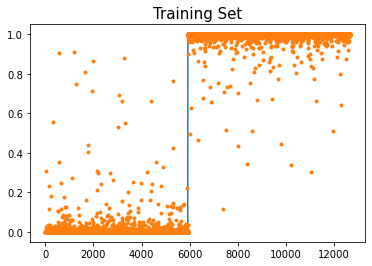

In [58]:
plt.plot(y)
plt.plot(net(X).data, '.')
plt.title('Training Set', size = 15)

# CNN 구현 (GPU)

## 1. dls

In [65]:
ds1 = torch.utils.data.TensorDataset(X, y)
ds2 = torch.utils.data.TensorDataset(XX, yy)

In [66]:
X.shape

torch.Size([12665, 1, 28, 28])

In [67]:
len(X) / 10

1266.5

In [68]:
len(XX)

2115

In [69]:
dl1 = torch.utils.data.DataLoader(ds1, batch_size = 1266)
dl2 = torch.utils.data.DataLoader(ds2, batch_size = 2115)

In [70]:
dls = DataLoaders(dl1, dl2)

## 2. lnrn 생성 : 아키텍처, 손실함수, 옵티마이저

In [71]:
net = torch.nn.Sequential(torch.nn.Conv2d(1, 16, (5, 5)),
                         torch.nn.ReLU(),
                         torch.nn.MaxPool2d((2, 2)),
                         torch.nn.Flatten(),
                         torch.nn.Linear(2304, 1),
                         torch.nn.Sigmoid())
loss_fn = torch.nn.BCELoss()

In [72]:
lrnr = Learner(dls, net, loss_fn)

## 3. 학습

In [73]:
lrnr.fit(10)

epoch,train_loss,valid_loss,time
0,0.991282,0.619085,00:03
1,0.670625,0.341608,00:00
2,0.503302,0.198077,00:00
3,0.387530,0.104358,00:00
4,0.299216,0.062006,00:00
5,0.233724,0.041215,00:00
6,0.185017,0.029626,00:00
7,0.148258,0.022577,00:00
8,0.120027,0.017928,00:00
9,0.097999,0.014688,00:00


## 4. 예측 및 시각화

In [74]:
net.to("cpu")

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

Text(0.5, 1.0, 'Training Set')

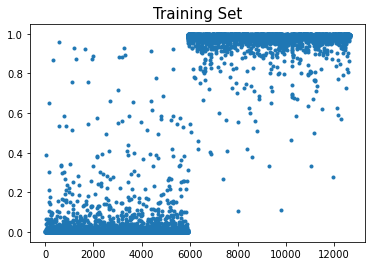

In [75]:
plt.plot(net(X).data, '.')
plt.title("Training Set", size = 15)

Text(0.5, 1.0, 'Test Set')

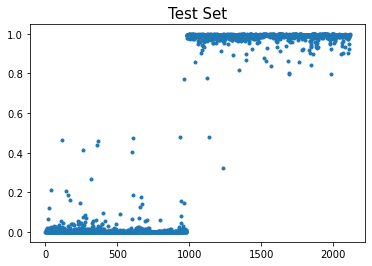

In [76]:
plt.plot(net(XX).data, '.')
plt.title("Test Set", size = 15)

`-` 빠르고 적합결과가 좋음

## Lrnr 오브젝트

In [77]:
lrnr.model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

In [78]:
net

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
  (5): Sigmoid()
)

In [79]:
id(lrnr.model), id(net)

(1730046488000, 1730046488000)

In [80]:
lrnr.model(X)

tensor([[0.0022],
        [0.0062],
        [0.0010],
        ...,
        [0.9944],
        [0.9928],
        [0.9961]], grad_fn=<SigmoidBackward0>)

# BCEWithLogitsLoss

`-` BCEWithLogitsLoss = Sigmoid + BCELoss

 - 사용하는 이유 : 수치적으로 더 안정적

## (1) dls 만들기

In [81]:
ds1 = torch.utils.data.TensorDataset(X, y)
ds2 = torch.utils.data.TensorDataset(XX, yy)

In [82]:
dl1 = torch.utils.data.DataLoader(ds1, batch_size = 1266)
dl2 = torch.utils.data.DataLoader(ds2, batch_size = 2115)

In [83]:
dls = DataLoaders(dl1, dl2)

## (2) lrnr 생성

In [84]:
net = torch.nn.Sequential(torch.nn.Conv2d(1, 16, (5, 5)),
                         torch.nn.ReLU(),
                         torch.nn.MaxPool2d((2, 2)),
                         torch.nn.Flatten(),
                         torch.nn.Linear(2304, 1),
                         # torch.nn.Sigmoid
                         )
loss_fn = torch.nn.BCEWithLogitsLoss()
lrnr = Learner(dls, net, loss_fn)

## (3) 학습

In [85]:
lrnr.fit(10)

epoch,train_loss,valid_loss,time
0,0.892442,0.606591,00:00
1,0.666649,0.397382,00:00
2,0.523290,0.242031,00:00
3,0.411065,0.128731,00:00
4,0.320348,0.071073,00:00
5,0.250880,0.044551,00:00
6,0.198633,0.031172,00:00
7,0.159071,0.023557,00:00
8,0.128692,0.018763,00:00
9,0.105028,0.015471,00:00


## (4) 예측 및 시각화

In [86]:
net.to('cpu')

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=2304, out_features=1, bias=True)
)

Text(0.5, 0.98, 'Training Set')

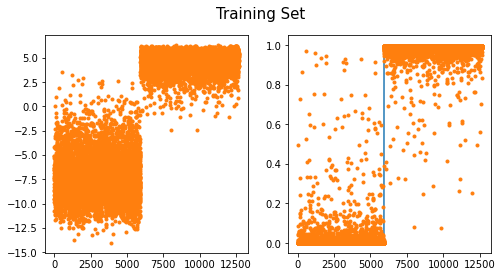

In [87]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
ax[0].plot(net(X).data, '.', color = 'C1')
ax[1].plot(y)
ax[1].plot(a2(net(X)).data, '.')
fig.suptitle('Training Set', size = 15)

Text(0.5, 0.98, 'Training Set')

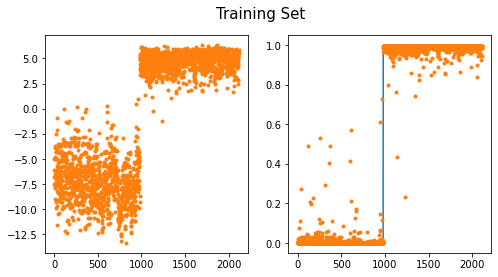

In [88]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
ax[0].plot(net(XX).data, '.', color = 'C1')
ax[1].plot(yy)
ax[1].plot(a2(net(XX)).data, '.')
fig.suptitle('Training Set', size = 15)

`-` IAB 딥러닝 수업 자료를 기반으로 공부한 내용입니다.